##Import various python functions and modules that we need.

In [2]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [3]:
%matplotlib inline
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [12]:
%%R
library(phyloseq)
library(vegan)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)

Loading required package: permute
Loading required package: lattice
This is vegan 2.2-1


##Import data into R. Prune to relevant samples (PS, non-bulk). Get rid of OTUs not observed in at least 25% of samples)

###These files are from the [binning notebook](./OTU_binning.ipynb), [tree notebook](./Tree.ipynb), [merge mappers notebook](./Merge_mappers.ipynb) 

In [5]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.PE = prune_samples((physeq.md$Bulk == 0), physeq)
physeq.PE.snorm = transform_sample_counts(physeq.PE, function(x) x/sum(x))
physeq.PE.thresh = filter_taxa(physeq.PE.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PE.thresh)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3203 taxa and 395 samples ]
sample_data() Sample Data:       [ 395 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 3203 tips and 3202 internal nodes ]


In [6]:
%%R
print(colnames(physeq.md))

 [1] "Sample"       "FractionNum"  "Bulk"         "Control"      "CC"          
 [6] "X100"         "X700"         "H2O"          "Day"          "Density"     
[11] "rep"          "contolVlabel" "Treatment"   


###Calculate pairwise weighted unifrac distances between samples.

In [7]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.PE.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

###Ordinate using weighted unifrac distances with NMDS.

In [8]:
%%R
nmds = ordinate(physeq.PE.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.08445914 
Run 1 stress 0.1070552 
Run 2 stress 0.08599338 
Run 3 stress 0.1002682 
Run 4 stress 0.09382721 
Run 5 stress 0.09615651 
Run 6 stress 0.09949003 
Run 7 stress 0.08584598 
Run 8 stress 0.4189444 
Run 9 stress 0.08843762 
Run 10 stress 0.1008269 
Run 11 stress 0.08737355 
Run 12 stress 0.1136004 
Run 13 stress 0.09214738 
Run 14 stress 0.08545565 
Run 15 stress 0.0868064 
Run 16 stress 0.09327842 
Run 17 stress 0.08781313 
Run 18 stress 0.1012296 
Run 19 stress 0.0936211 
Run 20 stress 0.1142509 


In [9]:
%%R
df = plot_ordination(physeq.PE.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

df2 = df %>%
    filter(Sample != c("13C.700.45.03.21", "12C.000.28.03.27"))
head(df2)

        NMDS1        NMDS2           Sample FractionNum Bulk Control CC X100
1 -0.07674907 -0.009170111 12C.700.45.01.24          24    0       1  0    0
2  0.06233234 -0.073443449 12C.700.14.06.14          14    0       1  0    0
3  0.04176666 -0.014015865 12C.100.14.05.18          18    0       1  0    1
4  0.03474841 -0.006613701 12C.700.14.06.05           5    0       1  0    0
5 -0.19227949 -0.012234820 12C.000.14.05.18          18    0       1  1    0
6  0.04622852 -0.033787976 12C.100.14.05.11          11    0       1  0    1
  X700 H2O Day Density rep contolVlabel Treatment
1    1   0  45  1.6783          control    12C700
2    1   0  14  1.7122          control    12C700
3    0   0  14  1.6980          control    12C100
4    1   0  14  1.7559          control    12C700
5    0   0  14  1.6936          control    12C000
6    0   0  14  1.7253          control    12C100


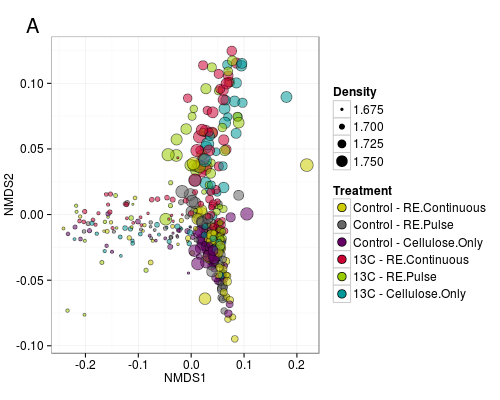

In [10]:
%%R -w 500 -h 400 

colours = c("#660066", "#CCCC00", "#666666", "#009999", "#CC0033", "#99CC00")

p1 = ggplot(df2, aes(x = NMDS1, y = NMDS2)) 

p1 = p1 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 

p1 = p1 + scale_fill_manual(values = colours,
                            breaks=c("12C100", "12C700", "12C000", "13C100", "13C700", "13C000"),
                            labels=c("Control - RE.Continuous", "Control - RE.Pulse", "Control - Cellulose.Only",
                                     "13C - RE.Continuous", "13C - RE.Pulse", "13C - Cellulose.Only"))

p1 = p1 + guides(alpha = FALSE)

p1 = p1 + scale_size_area(aesthetics = "Density")

p1 = p1 + ggtitle("A")

p1 = p1 + guides(fill = guide_legend(override.aes = list(size = 4)))
p1 = p1 + guides(size = guide_legend(override.aes = list(fill = "black")))

p1 = p1 + theme_bw()
p1 = p1 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20),
                axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12))

p1

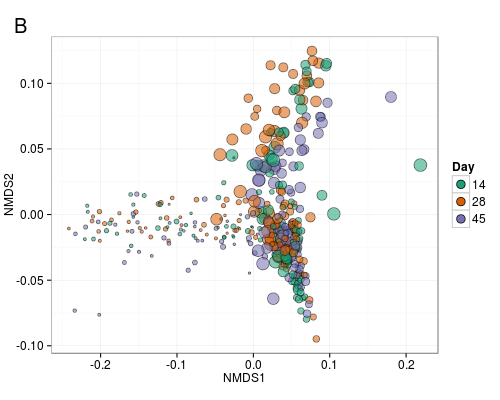

In [10]:
%%R -w 500 -h 400

p2 = ggplot(df2, aes(x = NMDS1, y = NMDS2))

p2 = p2 + geom_point(aes(fill = factor(Day), size = Density, alpha = 0.85), shape=21)

p2 = p2 + scale_fill_brewer(palette="Dark2")

p2 = p2 + guides(alpha = FALSE, size = FALSE)

p2 = p2 + scale_size_area(aesthetics = "Density")

p2 = p2 + ggtitle("B")

p2 = p2 + guides(fill = guide_legend(title = "Day", override.aes = list(size = 4)))

p2 = p2 + theme_bw()
p2 = p2 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p2 = p2 + theme(plot.title = element_text(hjust = -0.1, size = 20),
                axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12))

p2

NULL


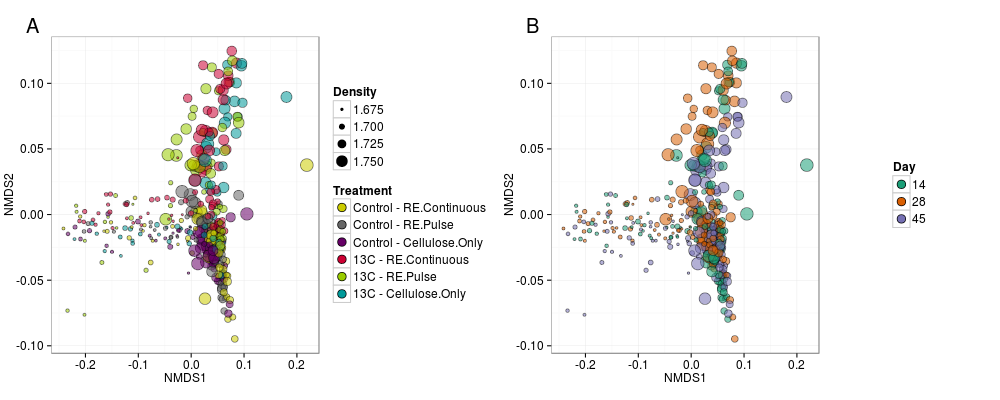

In [11]:
%%R -w 1000 -h 400

gp1 = ggplot_gtable(ggplot_build(p1))
gp2 = ggplot_gtable(ggplot_build(p2))
maxWidth = unit.pmax(gp1$widths[2:5], gp2$widths[2:5])

gp1$widths[2:5] <- maxWidth
gp2$widths[2:5] <- maxWidth

p.combined = grid.arrange(gp1, gp2, ncol = 2)
p.combined

In [12]:
%%R 
pdf("figs/full_ordination.pdf", width = 12, height = 5)
grid.arrange(p1, p2, widths = c(1.3, 1), ncol=2)
dev.off()

png 
  2 


In [13]:
FileLink("figs/full_ordination.pdf")

/home/ashley/priming_exp/figs/full_ordination.pdf

In [14]:
%%R 
png("figs/full_ordination.png", width = 12, height = 5, units = "in", res = 600)
grid.arrange(p1, p2, widths = c(1.3, 1), ncol=2)
dev.off()

png 
  2 


In [15]:
FileLink("figs/full_ordination.png")

/home/ashley/priming_exp/figs/full_ordination.png

In [5]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.C13 = prune_samples((physeq.md$Treatment %in% c("13C000","13C700", "13C100"))& (physeq.md$Bulk == 0), physeq)
physeq.C13.snorm = transform_sample_counts(physeq.C13, function(x) x/sum(x))
physeq.C13.thresh = filter_taxa(physeq.C13.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.C13)
print(physeq.C13.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10361 taxa and 206 samples ]
sample_data() Sample Data:       [ 206 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 10361 tips and 10360 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2893 taxa and 206 samples ]
sample_data() Sample Data:       [ 206 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 2893 tips and 2892 internal nodes ]


In [6]:
%%R
registerDoParallel(cores=10)
wunif.dist = distance(physeq.C13.thresh, 
                weighted = TRUE, 
                fast = TRUE, 
                normalized = FALSE, 
                parallel = TRUE)

In [7]:
%%R
nmds = ordinate(physeq.C13.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.0730302 
Run 1 stress 0.07151037 
... New best solution
... procrustes: rmse 0.009859652  max resid 0.08714335 
Run 2 stress 0.07247293 
Run 3 stress 0.07150962 
... New best solution
... procrustes: rmse 0.0006939333  max resid 0.009330164 
*** Solution reached


In [8]:
%%R
physeq.thresh.C13heavy = prune_samples(sample_data(physeq.C13.thresh)$Density >= 1.725, physeq.C13.thresh)

In [9]:
%%R
wunif.dist.C13heavy = distance(physeq.thresh.C13heavy, method = "unifrac", weighted = TRUE)

In [10]:
%%R
#convert physeq object to a dataframe for adonis test
df3 = sample_data(physeq.thresh.C13heavy)
#convert dataframe from physeq to a traditional R dataframe because it has funky 'class'
df3 = data.frame(df3)
head(df3)

                           Sample FractionNum Bulk Control CC X100 X700 H2O Day
13C.700.28.07.04 13C.700.28.07.04           4    0       0  0    0    1   0  28
13C.700.14.08.07 13C.700.14.08.07           7    0       0  0    0    1   0  14
13C.000.14.09.05 13C.000.14.09.05           5    0       0  1    0    0   0  14
13C.700.45.03.02 13C.700.45.03.02           2    0       0  0    0    1   0  45
13C.000.28.06.05 13C.000.28.06.05           5    0       0  1    0    0   0  28
13C.700.14.08.09 13C.700.14.08.09           9    0       0  0    0    1   0  14
13C.000.14.09.04 13C.000.14.09.04           4    0       0  1    0    0   0  14
13C.000.14.09.08 13C.000.14.09.08           8    0       0  1    0    0   0  14
13C.100.28.07.07 13C.100.28.07.07           7    0       0  0    1    0   0  28
13C.100.28.06.04 13C.100.28.06.04           4    0       0  0    1    0   0  28
13C.700.14.08.05 13C.700.14.08.05           5    0       0  0    0    1   0  14
13C.700.14.08.02 13C.700.14.08.02       

In [13]:
%%R
#to test if community composition in heavy fractions is different between treatments
adonis.wunif.heavy = adonis(wunif.dist.C13heavy ~ Treatment, data = df3, permutations = 1000)
adonis.wunif.heavy


Call:
adonis(formula = wunif.dist.C13heavy ~ Treatment, data = df3,      permutations = 1000) 

Permutation: free
Number of permutations: 1000

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2   Pr(>F)   
Treatment  2   0.13131 0.065653  3.0905 0.07431 0.001998 **
Residuals 77   1.63572 0.021243         0.92569            
Total     79   1.76703                  1.00000            
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
